# MNIST digits classificaiton

## Get the dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
#mnist['DESCR']

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

'5'

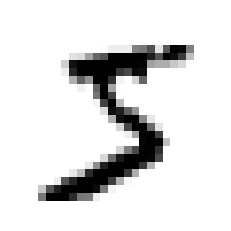

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
y[0]

## Data prep

### Make targets integers

In [5]:
import numpy as np

y = y.astype(np.uint8)

### Create the train/test partitions

In [6]:
boundary = 60000

X_train, X_test, y_train, y_test = X[:boundary], X[boundary:], y[:boundary], y[boundary:]

### Create labels for a binary classifier - detect '5'

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Train a stochastic gradient descent classifier

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Make a prediction

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## Evaluate the model

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Show that accuracy is a bad measure - always predict 'not 5'

In [12]:
from never_5_classifier import Never5Classifier

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])